# 코드설명
## CUDA(GPU사용), OPTUNA(최적화), VISDOM(시각화) 관련 내용을 제거한 코드입니다. 
### 첫번째 블럭과 두번째 블럭은 데이터가 잘 불러와 지는지, RP변환과 푸리에 변환이 잘 이루어지고 있는지 확인하는 코드입니다.
### 건너뛰어서 3번쨰 블럭(만족도 예측 모델) 부터 실행해보아도 됩니다.
### 3번쨰 블럭의 가중치가 네번째 블럭인 생성모델의 가중치로 사용되나, 이부분이 정확히 일치 하지 않습니다. 그냥 이런 방식으로 만들려고 했구나 정도로만 생각해도 될것 같습니다.
### CPU 만을 사용하므로 다소 느립니다. 

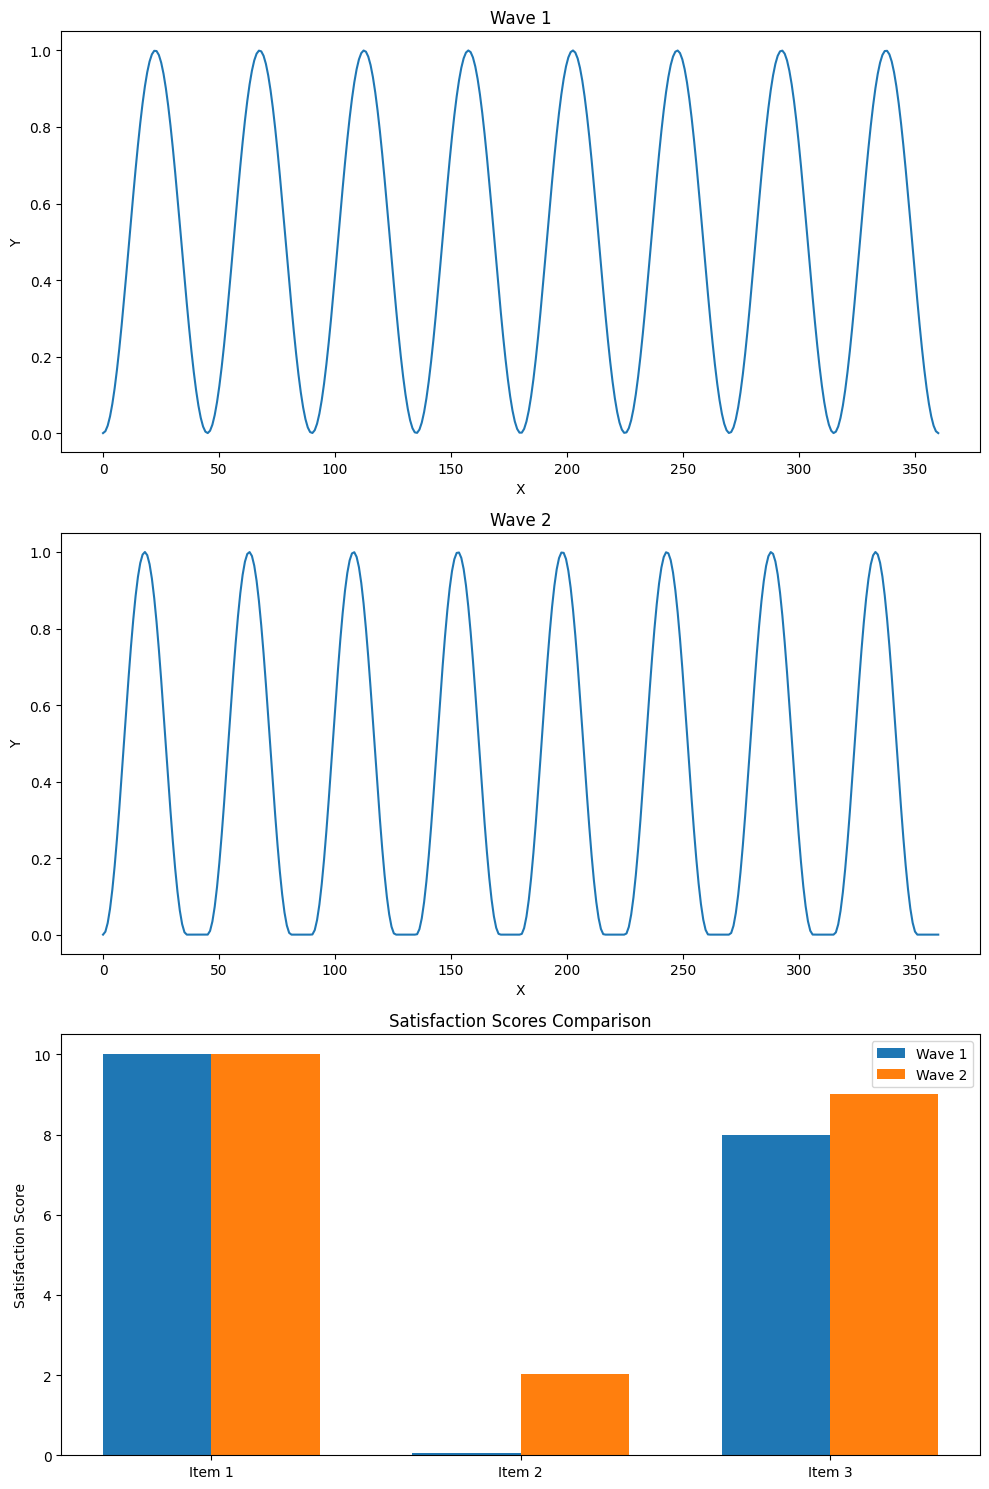

Wave 1 Satisfaction Scores: [9.99980855 0.05555556 8.        ]
Wave 2 Satisfaction Scores: [9.99980855 2.02777778 9.        ]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
df = pd.read_csv('simple_sample.csv', header=None)

# 첫 번째와 두 번째 파형 데이터 추출
wave1_scores = df.iloc[0:3, 0].values
wave1_x = df.iloc[0:, 1].values
wave1_y = df.iloc[0:, 2].values

wave2_scores = df.iloc[0:3, 3].values
wave2_x = df.iloc[0:, 4].values
wave2_y = df.iloc[0:, 5].values

# 그래프 그리기
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# 첫 번째 파형 그래프
ax1.plot(wave1_x, wave1_y)
ax1.set_title('Wave 1')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# 두 번째 파형 그래프
ax2.plot(wave2_x, wave2_y)
ax2.set_title('Wave 2')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# 만족감 점수 막대 그래프
categories = ['Item 1', 'Item 2', 'Item 3']
x = range(len(categories))
width = 0.35

ax3.bar([i - width/2 for i in x], wave1_scores, width, label='Wave 1')
ax3.bar([i + width/2 for i in x], wave2_scores, width, label='Wave 2')
ax3.set_ylabel('Satisfaction Score')
ax3.set_title('Satisfaction Scores Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(categories)
ax3.legend()

plt.tight_layout()
plt.show()

print("Wave 1 Satisfaction Scores:", wave1_scores)
print("Wave 2 Satisfaction Scores:", wave2_scores)

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.1 0.1]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.1 ... 0.  0.  0. ]
 [0.  0.  0.1 ... 0.  0.  0. ]]


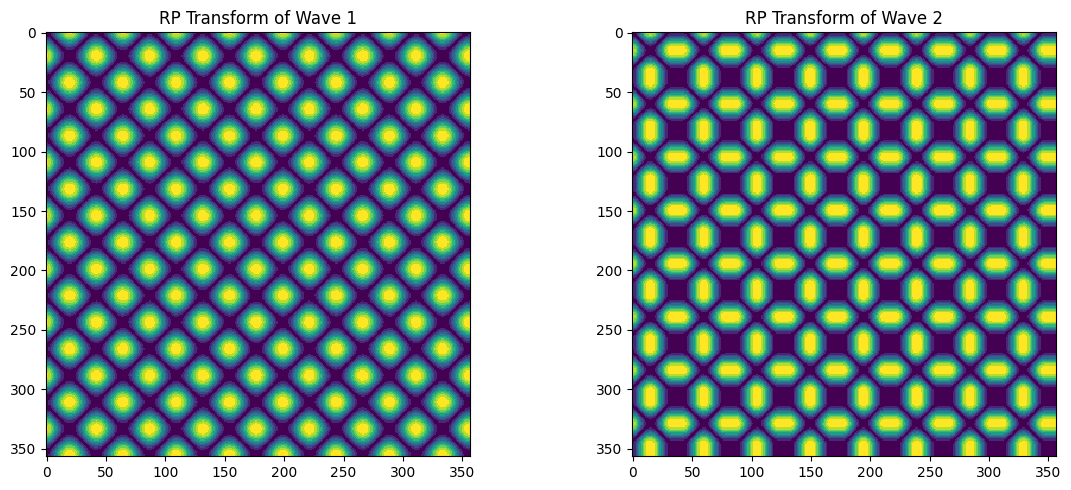


Fourier coefficients for Wave 1:
a0 (DC component): 0.043464871
an (Cosine coefficients, first 5): [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.13448063e-18
 4.49361977e-19]
bn (Sine coefficients, first 5): [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  9.63340256e-19
  5.43574783e-19]

All coefficients for Wave 1 (first 10):
[ 4.34648710e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.13448063e-18  4.49361977e-19  0.00000000e+00  2.01857704e-19
  8.91899412e-20 -6.45781649e-21]

Fourier coefficients for Wave 2:
a0 (DC component): 0.06735238199999999
an (Cosine coefficients, first 5): [-3.19669232e-18  0.00000000e+00  0.00000000e+00  1.13448063e-18
 -4.49361977e-19]
bn (Sine coefficients, first 5): [-5.68498601e-19 -0.00000000e+00 -0.00000000e+00  9.63340256e-19
 -5.43574783e-19]

All coefficients for Wave 2 (first 10):
[ 6.73523820e-02 -3.19669232e-18  0.00000000e+00  0.00000000e+00
  1.13448063e-18 -4.49361977e-19  1.29857103e-18  0.00000000e+00
  8.91899412e-20 -6.457

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import pandas as pd
from scipy.spatial.distance import pdist, squareform

# CSV 파일 읽기
df = pd.read_csv('simple_sample.csv', header=None)

# 첫 번째와 두 번째 파형 데이터 추출
wave1_x = df.iloc[3:, 1].values
wave1_y = df.iloc[3:, 2].values
wave2_x = df.iloc[3:, 4].values
wave2_y = df.iloc[3:, 5].values

# RP 변환 함수 (0과 1의 이진값으로 나옴.)
'''
def recurrence_plot(s, eps=0.10, steps=None):
    if steps is None:
        steps = len(s)
    d = np.zeros((steps, steps))
    for i in range(steps):
        for j in range(steps):
            d[i, j] = np.abs(s[i] - s[j])
    return (d < eps).astype(int)
'''
# Spearlab버전 RP변환함수(0~1사이의 값으로 나옴)
def recurrence_plot(s, eps=0.10, steps=10):
    s = s.reshape(-1, 1)  # 2D array로 변환
    d = pdist(s)
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z / steps  # 0과 1 사이의 값으로 정규화


# 수정된 푸리에 변환 함수
def fourier_transform(x, y):
    n = len(x)
    t = np.linspace(0, 1, n)
    interpolated_y = np.interp(t, x, y)
    fft_result = fft(interpolated_y)
    
    a0 = np.real(fft_result[0]) / n  # DC component
    an = 2 * np.real(fft_result[1:n//2]) / n  # Cosine coefficients
    bn = -2 * np.imag(fft_result[1:n//2]) / n  # Sine coefficients
    
    return a0, an, bn

# RP 변환 및 시각화 (이전과 동일)
plt.figure(figsize=(12, 5))

plt.subplot(121)
rp1 = recurrence_plot(wave1_y)
print(rp1)
plt.imshow(rp1, cmap='viridis', interpolation='nearest')
plt.title('RP Transform of Wave 1')

plt.subplot(122)
rp2 = recurrence_plot(wave2_y)
plt.imshow(rp2, cmap='viridis', interpolation='nearest')
plt.title('RP Transform of Wave 2')

plt.tight_layout()
plt.show()

# 푸리에 변환 및 결과 출력
for i, (x, y) in enumerate([(wave1_x, wave1_y), (wave2_x, wave2_y)], 1):
    a0, an, bn = fourier_transform(x, y)
    print(f"\nFourier coefficients for Wave {i}:")
    print(f"a0 (DC component): {a0}")
    print(f"an (Cosine coefficients, first 5): {an[:5]}")
    print(f"bn (Sine coefficients, first 5): {bn[:5]}")

    # 전체 계수 리스트 (a0, an, bn 순서)
    all_coeffs = np.concatenate(([a0], an, bn))
    print(f"\nAll coefficients for Wave {i} (first 10):")
    print(all_coeffs[:10])

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

# 데이터 로딩 및 전처리
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, header=None)
    num_waves = df.shape[1] // 3
    waves = []
    scores = []
    
    for i in range(num_waves):
        x = df.iloc[0:, i*3 + 1].values
        y = df.iloc[0:, i*3 + 2].values
        score = df.iloc[0:3, i*3].values
        
        waves.append((x, y))
        scores.append(score)
    
    return waves, np.array(scores)

# 푸리에 변환 함수
def fourier_transform(x, y):
    n = len(x)
    t = np.linspace(0, 1, n)
    interpolated_y = np.interp(t, x, y)
    fft_result = fft(interpolated_y)
    
    a0 = np.real(fft_result[0]) / n
    an = 2 * np.real(fft_result[1:n//2]) / n
    bn = -2 * np.imag(fft_result[1:n//2]) / n
    
    return np.concatenate(([a0], an, bn))

# 수정된 RP변환 함수
def recurrence_plot(s, eps=0.10, steps=10):
    s = s.reshape(-1, 1)  # 2D array로 변환
    d = pdist(s)
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z / steps  # 0과 1 사이의 값으로 정규화

# 데이터셋 클래스
class WaveformDataset(Dataset):
    def __init__(self, waves, scores):
        self.waves = waves
        self.scores = scores
        
    def __len__(self):
        return len(self.waves)
    
    def __getitem__(self, idx):
        x, y = self.waves[idx]
        fourier_coeffs = fourier_transform(x, y)
        rp_image = recurrence_plot(y)
        score = self.scores[idx]
        
        return (
            torch.FloatTensor(fourier_coeffs),
            torch.FloatTensor(rp_image).unsqueeze(0),
            torch.FloatTensor(score)
        )

# RNN 모델
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, hidden = self.rnn(x.unsqueeze(1))
        output = self.fc(hidden.squeeze(0))
        return output

# CNN 모델
class CNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # 동적으로 fully connected 층의 입력 크기 계산
        with torch.no_grad():
            x = torch.zeros(1, 1, input_size, input_size)
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.pool(torch.relu(self.conv2(x)))
            self.fc_input_size = x.numel()
        
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 멀티모달 모델
class MultimodalModel(nn.Module):
    def __init__(self, rnn_input_size, rnn_hidden_size, cnn_input_size, output_size):
        super(MultimodalModel, self).__init__()
        self.rnn = RNNModel(rnn_input_size, rnn_hidden_size, output_size)
        self.cnn = CNNModel(cnn_input_size, output_size)
        
    def forward(self, rnn_input, cnn_input):
        rnn_output = self.rnn(rnn_input)
        cnn_output = self.cnn(cnn_input)
        return (rnn_output + cnn_output) / 2

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_mse = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for fourier_coeffs, rp_images, scores in train_loader:
            optimizer.zero_grad()
            
            outputs = model(fourier_coeffs, rp_images)
            loss = criterion(outputs, scores)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Test 데이터에서 성능 평가
        model.eval()
        predictions, actual_scores = predict(model, test_loader)
        mse = np.mean((predictions - actual_scores) ** 2)
        print(f'Test MSE after Epoch {epoch+1}: {mse:.4f}')
        
        # Best 모델 저장
        if mse < best_mse:
            best_mse = mse
            torch.save(model.state_dict(), 'best_model.pth')
            print('Saved new best model with MSE:', mse)

# 예측 함수
def predict(model, data_loader):
    model.eval()
    predictions = []
    actual_scores = []
    
    with torch.no_grad():
        for fourier_coeffs, rp_images, scores in data_loader:
            outputs = model(fourier_coeffs, rp_images)
            predictions.append(outputs.numpy())
            actual_scores.append(scores.numpy())
    
    return np.concatenate(predictions), np.concatenate(actual_scores)

# 메인 실행 부분
if __name__ == "__main__":
    # 데이터 로드 및 전처리
    waves, scores = load_and_preprocess_data('simple_sample.csv')
    
    # 데이터셋 생성
    dataset = WaveformDataset(waves, scores)
    
    # 데이터 분할 (80% train, 20% test)
    num_samples = len(dataset)
    train_size = int(0.8 * num_samples)
    test_size = num_samples - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # 모델 파라미터 설정
    sample_fourier, sample_rp, _ = dataset[0]
    rnn_input_size = sample_fourier.size(0)
    cnn_input_size = sample_rp.size(1)
    rnn_hidden_size = 64
    output_size = 3
    
    # 모델, 손실 함수, 옵티마이저 초기화
    model = MultimodalModel(rnn_input_size, rnn_hidden_size, cnn_input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # 학습 실행
    num_epochs = 40
    train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
    
    print("Training completed.")
    
    # 최상의 모델로 예측 수행
    model.load_state_dict(torch.load('best_model.pth'))
    predictions, actual_scores = predict(model, test_loader)
    print("test 데이터와의 결과가 가장 좋았던 모델을 불러올거임")
    # 결과 출력
    for i in range(len(predictions)):
        print(f"Waveform {i+1}:")
        print(f"Predicted scores: {predictions[i]}")
        print(f"Actual scores: {actual_scores[i]}")
        print()
    
    # 전체 MSE 계산
    mse = np.mean((predictions - actual_scores) ** 2)
    print(f"Overall MSE: {mse}")

Epoch 1/40, Loss: 45.9594
Test MSE after Epoch 1: 20.6313
Saved new best model with MSE: 20.631306
Epoch 2/40, Loss: 19.7519
Test MSE after Epoch 2: 17.2498
Saved new best model with MSE: 17.249788


KeyboardInterrupt: 

Using CPU for computation


C:\Users\jaesik\AppData\Local\Temp\ipykernel_18588\892633564.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location='cpu')


Loaded pretrained weights from best_model.pth
Loaded 0 compatible layers out of 10 total layers


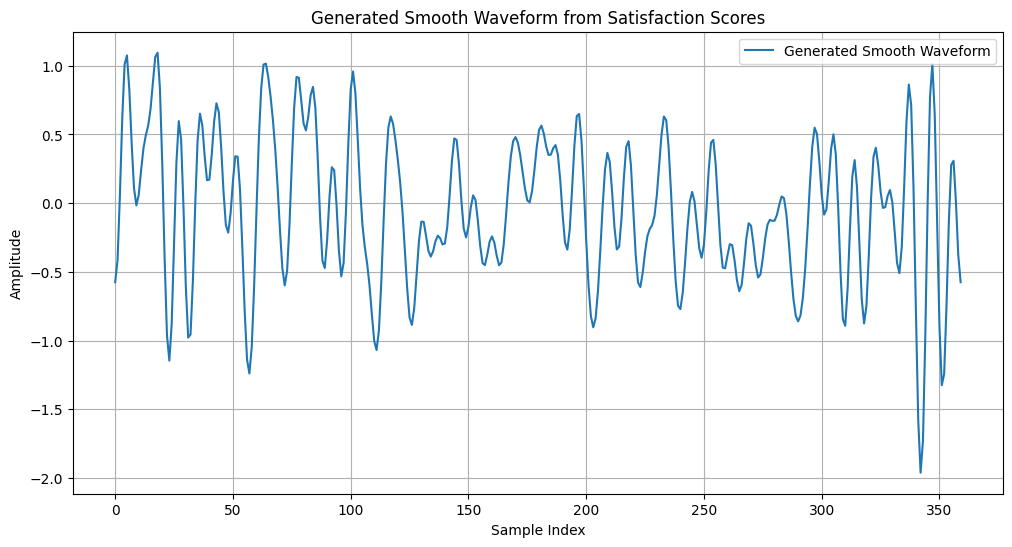

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class ImprovedWaveformGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, num_fourier_coeffs):
        super(ImprovedWaveformGenerator, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_fourier_coeffs * 2)  # *2 for both real and imaginary parts
        self.num_fourier_coeffs = num_fourier_coeffs

    def forward(self, satisfaction_scores):
        rnn_output, _ = self.rnn(satisfaction_scores.unsqueeze(1))
        fourier_coeffs = self.fc(rnn_output.squeeze(1))
        return fourier_coeffs

def generate_smooth_waveform(model, satisfaction_scores, num_samples=360):
    model.eval()
    with torch.no_grad():
        fourier_coeffs = model(satisfaction_scores)
        
    # 실수부와 허수부 분리
    real_parts = fourier_coeffs[:, :model.num_fourier_coeffs]
    imag_parts = fourier_coeffs[:, model.num_fourier_coeffs:]
    
    # 복소수 푸리에 계수 생성
    complex_coeffs = torch.complex(real_parts, imag_parts)
    
    # 푸리에 역변환
    time = torch.linspace(0, 1, num_samples)
    waveform = torch.zeros(num_samples)
    for n in range(model.num_fourier_coeffs):
        waveform += torch.real(complex_coeffs[0, n] * torch.exp(1j * 2 * np.pi * n * time))
    
    return waveform.numpy()

def load_pretrained_weights(model, weights_path):
    try:
        state_dict = torch.load(weights_path, map_location='cpu')
        model_state_dict = model.state_dict()
        
        # 호환되는 가중치만 로드
        compatible_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and v.shape == model_state_dict[k].shape}
        model_state_dict.update(compatible_state_dict)
        model.load_state_dict(model_state_dict)
        
        print(f"Loaded pretrained weights from {weights_path}")
        print(f"Loaded {len(compatible_state_dict)} compatible layers out of {len(model_state_dict)} total layers")
    except FileNotFoundError:
        print(f"Weights file {weights_path} not found. Using randomly initialized weights.")
    except Exception as e:
        print(f"Error loading weights: {str(e)}. Using randomly initialized weights.")

if __name__ == "__main__":
    print("Using CPU for computation")
    
    # 모델 파라미터 설정
    input_size = 3  # 만족도 점수가 3개
    hidden_size = 128
    num_fourier_coeffs = 50  # 생성할 푸리에 계수의 수
    model = ImprovedWaveformGenerator(input_size, hidden_size, num_fourier_coeffs)
    
    # 가중치 로드 시도
    load_pretrained_weights(model, 'best_model.pth')

    # 만족도 점수
    satisfaction_scores = torch.tensor([[10, 10, 10]], dtype=torch.float32)

    # 부드러운 파형 생성
    generated_waveform = generate_smooth_waveform(model, satisfaction_scores)

    # 그래프 표시
    plt.figure(figsize=(12, 6))
    plt.plot(generated_waveform, label='Generated Smooth Waveform')
    plt.title('Generated Smooth Waveform from Satisfaction Scores')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# 현재 진행상황
## 업데이트 내역
* 9월 23일까지:
  * RP변환, 푸리에 변환 코드를 Chatgpt코드가 아닌 승원, 승현님이 손보신 코드로 바꾸어 넣었음.
  * 멀티모달 하이퍼 파라미터 최적화 과정 추가(OPTUNA 라이브러리 사용, 간단하게 만든거라 잘 작동하는지는 (?))
  * 파형 생성과정에서 y좌표를 생성하는 것이 아닌 동일한 푸리에계수를 생성하도록 만들었음. 추가로 함수를 좀 부드럽게 만들어 달라고했는데 잘작동하고 있는지는 (?) 

# 개선,고려해야할 방향
## 데이터 부분

* 데이터 크기:
  * 최근 만든 큰 데이터로는 학습에 3시간 정도가 소요됨.
문제는 OPTUNA를 추가했는데, OPTUNA를 사용했을때 하이퍼 파라미터 최적화 과정에서 학습을 또 하기 때문에 시간이 배로 불어나서, 데이터 크기가 줄어야 할 필요성이있음. (저도 컴퓨터 써야돼요 ㅠㅠ)
**데이터 크기가 어느정도가 적당한지와, 데이터가 많아도 학습 속도를 빠르게 할 수 있는 방법에 대해서 생각해보아야함.**

## 멀티모달 모델 부분
* 모델의 완성도:
  * **파형 -> 만족도 카테고리별 train data에 대한 예측 자체는 어느 정도 수행하고 있음. loss값이 0.001 아래로 떨어지는편. 제대로 만든 데이터로 돌렸을 때 test_data와의 MSE는 2정도( 이상적인 모델의 경우 1 아래가 적합하긴 함).**
제대로 예측하고 있지 못하는 부분은 실제 점수가 매우 높거나 낮은 경우에 잘 예측 하고 있지 못함. 예측 하고 있는 값이 중앙에 편중되어 있다는 것을 알 수 있음.

* OPTUNA 하이퍼 파라미터 최적화:
  * 현재 코드에서는 OPTUNA를 사용하여 하이퍼파라미터 최적화를 진행한뒤(이 과정에서도 학습을 하긴함) 최종 학습을 진행하고 있음. 최적화 되고 있는 파라미터는 RNN모델의 가중치와 CNN모델의 가중치임. 기존에는 이 둘을 0.5, 0.5로 놓고 진행하였음. 
보통 ai학습에서는 학습과 하이퍼 파라미터 최적화 를 동시에 진행함. optuna를 사용하면 간편하지만 이 방식이 현재 코드와 적절한지 평가해 볼수 있음.
그리고 원래 RNN 레이어의 가중치가 0.5, CNN 레이어의 가중치가 0.5일때도 예측 자체는 잘 수행하였음. 여기서 RNN레이어와 CNN레이어의 가중치를 변경하는 것이 어떤의미가 있는지에 대해서 고찰해볼 필요성이 있음.**현 생성 모델에서 RNN 모델 내부의 가중치만 반영되는것과 같이 고려하였을때 레이어의 가중치를 하이퍼 파라미터 최적화하는것이 어떤 의미를 가질지 생각해 보아야함.**
추가로 지금 최적화 과정에 학습률과 손실함수 같은 다른 요소들은 들어가 있지 않음. 현재 모델이 train data에 대해서는 잘 예측하고 있기 때문에 크게 중요하진 않으나, 이를 수정했을때 test_data에 대해서도 잘 예측할 수 있지 않을까 생각됨.

* CNN모델 내부:
  * CNN학습에서 보통 들어가는 데이터가 많으면 적절하게 batch 사이즈를 나눠 크기를 조절하는데 이 과정이 빠졌음. 또 지금 CNN은 완전 기초적인 CNN인데, 여기서 CNN의 파생 모델들을 사용하는 것을 고려해 볼 수 있을 것 같음.(Resnet, mobilenet)등등등.. 또 CNN의 학습 과정중 학습중인 레이어를 시각화 하여 각 레이어가 학습에 어떻게 반영 될 수 있는지 알아 볼 수 있는데, 이 과정을 진행해 보는 것도 괜찮을 것 같음.
 
* RNN모델 내부:
  * 현재 GRU+FC 의 조합으로 진행하고 있는데, 이보다 더 나은 조합들을 시도해 볼수 있을 것같음.
  * 승원님 아이디어로, 푸리에 변환대신 y좌표로 학습을 시켜봐서 푸리에 변환의 의미를 알아보는 것도 좋을 것같음.

* 모델 전반:
  * **RNN만 학습했을때, CNN만 학습했을때의 결과를 비교해 보아서 멀티모달의 장점이 무엇인지 정리할 필요성이 있음. 위의 하이퍼 파라미터 최적화의 의미와 연결되는부분** 이건 원본 코드에서 조금만 바꿔도 되기 떄문에(모델을 합칠때 0.5,0.5 가중치를 조절해주면 됨) 금방 할 수 있을것 같음.`
  * 각 모델의 은닉층, 신경망 구조가 제대로 검토된 적은 없음. CNN의 경우 다소 깊고 넓은 은닉층이 사용되고 있으나, RNN의 구조는 너무 단순한것 같기도함. 또 어떤 활성화 함수를 사용하는것이 적절한 지 잘 모르겠음..

## 파형 생성모델
* 모델의 완성도:
  * **아직 제대로 생성을 못하고 있다고 볼 수 있음.** 지금까지의 방향은 위의 멀티 모달 모델의 RNN부분의 가중치와 구조를 가져와 파형 생성에 사용하고 있는데, 사실 위에서는 GRU->FC 로 푸리에계수-> 만족도를 구하는 구조고, 생성모델에서는 만족도 -> 푸리에계수로 만들어야하는데 모델 구조를 동일하게 GRU->FC로 사용하고 있음. 결과가 거꾸로라면 모델 구조도 거꾸로 FC-> GRU로 뒤집고, 가중치도 모델 구조를 다 뜯어봐서 거꾸로 뒤집어 넣어야 하는게 맞다고 생각됨..( 근데 제 실력이 부족합니다.. )
  * 또 가중치를 불러와 사용하는 것에 대해 CHATGPT나 CLAUDE 는 부정적인 입장인것 같음. 제가 생각한 대체방안으로는 멀티 모달자체를 파형 생성 모델 안에 집어넣어서 새로 학습을 시키는 방안을 찾거나, 멀티 모달을 양방향 예측 모델로 만드는 것이 좋을 것같으나 이부분 역시 많이 공부가 필요한 부분이라 시간안에 할 수 있을지 모르겠음.
  * 또 지금과 같은 구조에서는 코드를 돌릴때마다 다른 파형을 뱉어냅니다.

# 프로젝트 진행
* 위에서 적어놓은 것처럼 개선해야할 부분이 많이 있습니다. 워낙 모델의 구조가 복잡하고 확인해야 할 부분도 많기 때문에 부족한 제 실력으로 다 할수 있을 지 모르겠습니다.
* GPU를 사용하지 않는 코드를 공유해 드릴 수 있습니다.. 만약 여력이 되신다면 코드 제작에 같이 도움을 주셨으면 합니다. ㅠㅠ